In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import os
import re
import pickle

from IPython.core.display import display, HTML
from tqdm.auto import tqdm


plt.style.use('seaborn')
%matplotlib inline
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:90% !important; }</style>"))

# Data Load

motion, hear rate, label 사용

In [3]:
def get_number(filename):
    return int(re.search(r'\d+', filename).group())


# motion 데이터 프레임 리스트  
motion = []
dir_name = ''
path = ''
file_list = os.listdir(path)
file_list_txt = sorted([file for file in file_list], key=get_number)
for i in file_list_txt:
    df = pd.read_csv(dir_name+i,  sep=' ', header=None, names=['time', 'x', 'y', 'z'])
    motion.append(df)


# hear rate 데이터 프레임 리스트
heart_rate = []
dir_name = ''
path = ''
file_list = os.listdir(path)
file_list_txt = sorted([file for file in file_list], key=get_number)
for i in file_list_txt:
    df = pd.read_csv(dir_name+i, header=None, names=['time', 'bpm'])
    heart_rate.append(df)
    

# label 데이터 프레임 리스트
label = []
dir_name = ''
path = ''
file_list = os.listdir(path)
file_list_txt = sorted([file for file in file_list], key=get_number)
for i in file_list_txt:
    df = pd.read_csv(dir_name+i, sep=' ', header=None, names=['time', 'label'])
    label.append(df)

# motion preprocessing

**Band-pass filtering**

: 선행 연구처럼 중력 성분 영향을 제거하기 위해서 band-pass filtering 사용 (10Hz)

In [14]:
from scipy.signal import butter, filtfilt

# 샘플링 주파수와 절반 주파수 설정
fs = 10 
fn = fs/2

band_motion = []
col_names = ['x', 'y', 'z']

for i in range(len(motion)):
    sub = motion[i].drop('time' ,axis=1)

    # 밴드 필터링된 데이터 배열 초기화
    band_data = np.zeros(sub.shape)

    # 각 채널에 대해 필터링 수행
    for ch in range(3):
        x = sub.iloc[:, ch]
        b, a = butter(3, 0.5 / fn, btype='high')
        band_data[:, ch] = filtfilt(b, a, x) 
    
    # 밴드 필터링된 데이터를 데이터프레임 형식으로 변환
    df = pd.DataFrame(band_data, columns=col_names)
    
    # 시간 컬럼 추가
    res = pd.concat([motion[i]['time'], df], axis=1)
    band_motion.append(res)

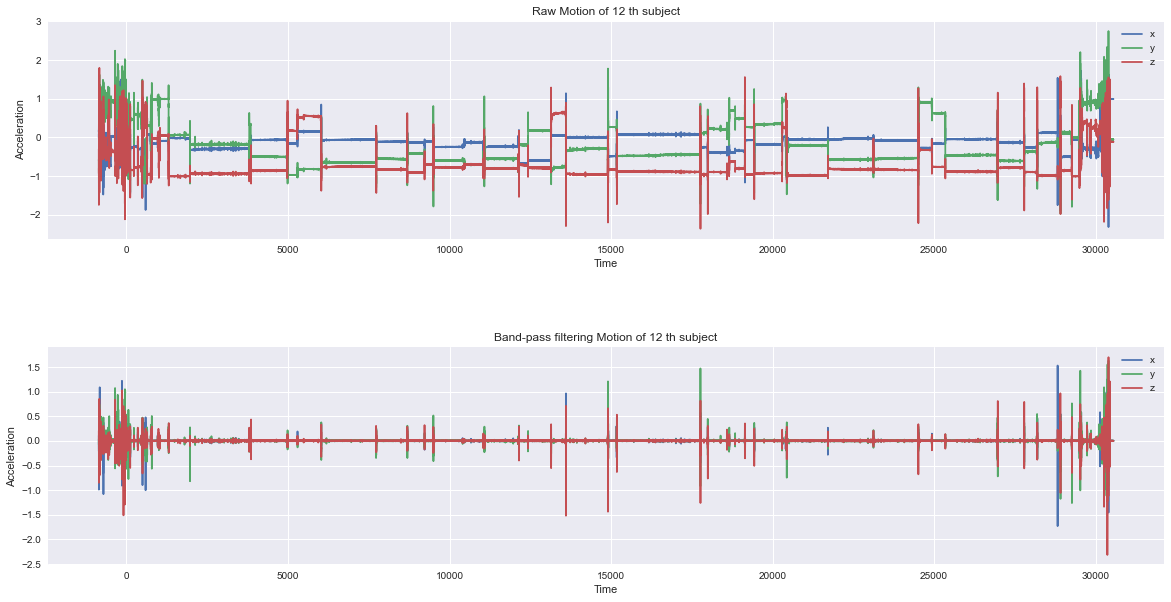

In [16]:
# band-pass filtering 전후 그래프 확인

f, ax = plt.subplots(2, 1, figsize=(20,10))

motion[12].plot(x='time', y=['x', 'y', 'z'], ax=ax[0])

# 그래프 제목 설정
ax[0].set_title('Raw Motion of 12 th subject')

# 축 레이블 설정
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Acceleration')

band_motion[12].plot(x='time', y=['x', 'y', 'z'], ax=ax[1])

# 그래프 제목 설정
ax[1].set_title('Band-pass filtering Motion of 12 th subject')

# 축 레이블 설정
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Acceleration')


# subplot 간의 수직 간격 조절
plt.subplots_adjust(hspace=0.5)

plt.show()

# Label 크기에 맞게 데이터 segment

* motion/heart rate의 시작 데이터를 PSG 측정 시작 시간부터 되도록 데이터 정리
* motion/heart rate의 마지막 시간과 label의 마지막 시간이 맞지 않아 이를 label에 맞춰 데이터를 정리한다.

## time to int

시간을 정수형으로 변환시켜 계산하기 편하게 설정한다.

In [17]:
# motion time을 int형으로 바꿈
for i in range(len(band_motion)):
    band_motion[i]['time'] = band_motion[i]['time'].astype(int)
    

# hear_rate time int형으로 바꿈
for i in range(len(heart_rate)):
    heart_rate[i]['time'] = heart_rate[i]['time'].astype(int)

In [18]:
# 잘 변환되었는지 확인
band_motion[0].head()

,time,x,y,z
0,-124489,-0.000193,0.000295,0.000231
1,-124489,0.000224,-0.003133,-0.002445
2,-124489,0.001090,0.005249,-0.007707
3,-124489,-0.001526,0.004942,-0.005789
4,-124489,-0.005133,-0.001598,0.001742


In [19]:
# 잘 변환되었는지 확인
heart_rate[0].head()

,time,bpm
0,-556410,57
1,-556408,56
2,-556403,56
3,-556399,57
4,-556389,59


## 데이터의 시간을 [PSG 측정 시작 시간, Label 마지막 시간]으로 설정

In [20]:
# 측정 시간을 0초 ~ label의 맨 마지막 초 까지만 포함

for i in range(len(band_motion)):
    band_motion[i] = band_motion[i][(band_motion[i]['time'] >= 0) & (band_motion[i]['time'] <= label[i]['time'].max())]
    heart_rate[i] = heart_rate[i][(heart_rate[i]['time'] >= 0) & (heart_rate[i]['time'] <= label[i]['time'].max())]

In [21]:
print('sub / len heart_rate time / len motion time / max motion time / max label time')

for i in range(len(band_motion)):
    print(i, len(heart_rate[i]['time'].unique()), len(band_motion[i]['time'].unique()), band_motion[i]['time'].max(), label[i]['time'].max())

sub / len heart_rate time / len motion time / max motion time / max label time
0 3302 16981 16980 16980
1 2843 13586 14220 14220
2 5652 29302 29400 29400
3 5467 28362 28440 28440
4 4964 23773 28394 28530
5 5574 27692 29010 29010
6 5549 26358 28920 28920
7 5717 29671 29670 29670
8 5702 29611 29610 29610
9 5334 25318 29460 29460
10 5537 29041 29040 29040
11 2496 12481 12480 12480
12 5673 29281 29280 29280
13 3054 14795 14940 15270
14 5575 29071 29070 29070
15 5637 29371 29370 29370
16 2784 13907 13920 13920
17 5609 29302 29310 29310
18 4382 22662 22740 22740
19 5584 28831 28830 28830
20 5691 29431 29430 29430
21 837 3901 4024 28770
22 5581 28506 28920 28920
23 5652 29521 29520 29520
24 5625 29131 29130 29130
25 5526 26864 28950 28950
26 5618 29101 29100 29100
27 5537 28921 28920 28920
28 5619 29202 29220 29220
29 5421 28321 28320 28320
30 4007 21571 21570 21570


# Subject Select

다음 조건을 만족하는 피험자만 선택

* 수면 시간이 7.5시간 이상
* 수면 단계 중간에 -1(unscored)이 없는 피험자
* 수면 단계 모두 나타나는 피험자
* 라벨링 이상이 없는 피험자( ex) 중간에 4가 있는 피험자 존재하므로)


**최종적으로 16명의 피험자의 수면 분류**


In [22]:
# 수면 시간이 7.5시간이 안 되는 피험자는 제외 (label[i]['time'].max() < 27000이면 제외 )

less_sleep_idx = set()

for i in range(len(band_motion)):
    if label[i]['time'].max() < 27000:
        less_sleep_idx.add(i)

less_sleep_idx

{0, 1, 11, 13, 16, 18, 30}

In [23]:
# 중간에 -1이 있는 피험자 제외

label_err = {6, 17, 19, 22, 24, 25} 

err_sub_idx = less_sleep_idx | label_err

len(err_sub_idx), err_sub_idx

(13, {0, 1, 6, 11, 13, 16, 17, 18, 19, 22, 24, 25, 30})

In [24]:
select_sub_idx = list(set(range(31)) - err_sub_idx)

select_sub_idx

[2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 20, 21, 23, 26, 27, 28, 29]

In [25]:
# 선택된 피험자만 넘파이 배열로 변환

heart_rate = np.array(heart_rate, dtype=object)[select_sub_idx]
label = np.array(label, dtype=object)[select_sub_idx]
band_motion = np.array(band_motion, dtype=object)[select_sub_idx]

In [27]:
for i in range(len(label)):
    print(label[i]['label'].unique())

[0 5 1 2 3]
[-1  0  1  2  3  5]
[0 1 2 3 5]
[-1  0  1  2  3  5]
[-1  0  1  2  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[0 1 2 3 5]
[-1  0  2  1  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[-1  0  1  2  3  5]
[0 1 2 3 4 5]


In [32]:
# 깊은 수면이 없고 라벨이 4가 있는 피험자 제외

heart_rate = np.delete(heart_rate, [4, -1], axis=0)
label = np.delete(label, [4, -1], axis=0)
band_motion = np.delete(band_motion, [4, -1], axis=0)

In [33]:
# 최종적으로 16명의 피험자의 수면을 분류할 예정
len(heart_rate), len(label), len(band_motion)

(16, 16, 16)

# Heart rate preprocessing

선행 연구에서 진행된 전처리 방식으로 heart rate 전처리 진행

* hear rate interpolate : 매 1초 기록으로 보간

* difference Gaussian filter :  (σ1 = 120 seconds, σ2 = 600 seconds)

* scaling : 심박수 측정값과 수면 기간 동안 평균 심박수 사이의 절대값 차이의 90번째 백분위수로 나누어 정규화

## Data Interpolate

In [34]:
interpol_heart_rate = []

for i in range(len(heart_rate)):
    df = heart_rate[i]

    # 보간할 시간 범위 생성
    interpol_time_range = np.arange(df['time'].min(), df['time'].max() + 1)

    # 누락된 시간에 대한 bpm 값 NaN으로 설정한 새로운 데이터프레임 생성
    interpol_df = pd.DataFrame({'time': interpol_time_range})
    interpol_df['bpm'] = np.nan

    # 원본 데이터와 보간된 데이터프레임을 합치기
    new_df = pd.concat([df, interpol_df], ignore_index=True)

    #중복된 time 제거 (interpol_df의 NAN을 제거)
    new_df = new_df.drop_duplicates(subset='time', keep='first')

    # 시간을 기준으로 정렬
    new_df = new_df.sort_values('time')

    # NaN 값 채우기
    new_df['bpm'].interpolate(inplace=True)

    # 인덱스 초기화
    new_df = new_df.reset_index(drop=True)
    
    interpol_heart_rate.append(new_df)


In [35]:
# 보간이 잘되었는지 확인
interpol_heart_rate[0].head(20)

,time,bpm
0,1,65.000000
1,2,65.000000
2,3,65.000000
3,4,65.000000
4,5,65.000000
5,6,65.000000
6,7,65.222222
7,8,65.444444
8,9,65.666667
9,10,65.888889


## Gaussian Filter

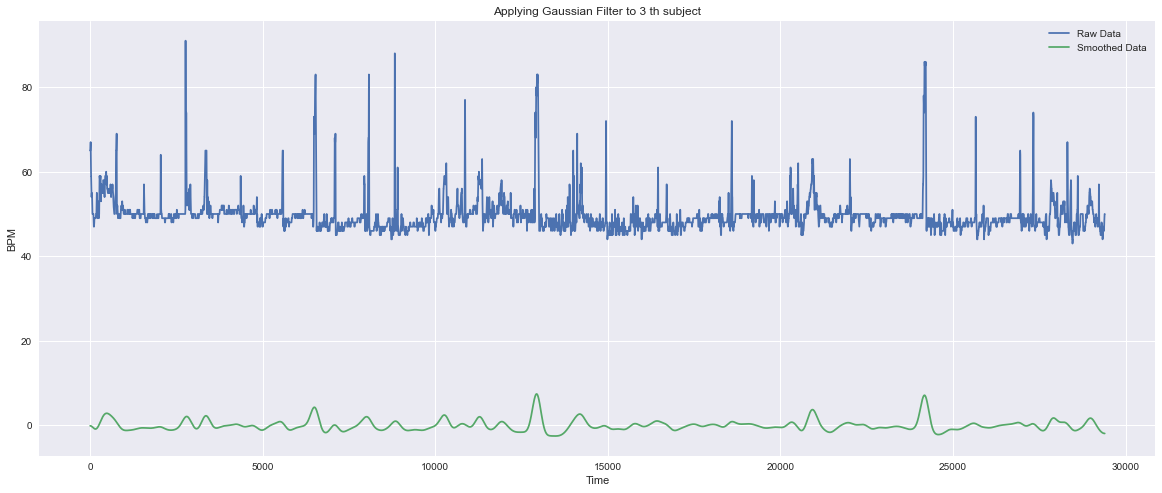

In [36]:
from scipy.ndimage import gaussian_filter


## 예시
data = interpol_heart_rate[0]['bpm']

# 차이 가우시안 필터 적용
sigma1 = 120  # 첫 번째 가우시안 필터의 표준편차
sigma2 = 600  # 두 번째 가우시안 필터의 표준편차

gaussian_smoothed = gaussian_filter(data, sigma1) - gaussian_filter(data, sigma2)

# 결과 시각화
plt.figure(figsize=(20, 8))
plt.plot(data, label='Raw Data')
plt.plot(gaussian_smoothed, label='Smoothed Data')
plt.xlabel('Time')
plt.ylabel('BPM')
plt.title('Applying Gaussian Filter to 3 th subject')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
filter_heart_rate = []

# 차이 가우시안 필터 적용
sigma1 = 120  # 첫 번째 가우시안 필터의 표준편차
sigma2 = 600  # 두 번째 가우시안 필터의 표준편차

for i in range(len(heart_rate)):
    data = interpol_heart_rate[i]['bpm']
    gaussian_smoothed = gaussian_filter(data, sigma1) - gaussian_filter(data, sigma2)
    
    df = pd.DataFrame({'time': interpol_heart_rate[i]['time'], 'bpm': gaussian_smoothed})
    filter_heart_rate.append(df)

## Scaling

In [38]:
# 정규화 함수 정의
def normalize_data(df):
    avg = df['bpm'].mean()
    diff = np.abs(df['bpm'] - avg)
    percentile_90 = np.percentile(diff, 90)
    normalized_value = df['bpm'] / percentile_90
    return normalized_value

for i in range(len(filter_heart_rate)):
    filter_heart_rate[i]['bpm'] = normalize_data(filter_heart_rate[i])    

# 잘 되었는지 확인
filter_heart_rate[0]

,time,bpm
0,1,-0.060843
1,2,-0.060921
2,3,-0.061078
3,4,-0.061312
4,5,-0.061626
...,...,...
29393,29394,-1.007394
29394,29395,-1.007552
29395,29396,-1.007670
29396,29397,-1.007749


# Label preprocessing

현재 선택된 피험자의 수면 라벨링이 있는데 이는 시작과 끝에만 있는 것으로 확인됨

그래서 -1을 0(wake)로 치환 (wake여서 점수를 안 메기지 않았을까 라고 생각)

In [39]:
for i in range(len(label)):
    label[i]['label'].replace(-1, 0, inplace=True)

# Feature Selection

선행 연구에서 수면 분류에 효과적인 feature 선택

functions = {mean, var, rms, max, std, Katz_FD}

최종적으로 피험자별 24개의 feature를 가짐

In [40]:
def katz_fd(x, axis=-1):
    """Katz Fractal Dimension.

    Parameters
    ----------
    x : list or np.array
        1D or N-D data.
    axis : int
        The axis along which the FD is calculated. Default is -1 (last).

    Returns
    -------
    kfd : float
        Katz fractal dimension.

    Notes
    -----
    Katz’s method calculates the fractal dimension of a sample as follows:
    the sum and average of the Euclidean distances between the successive
    points of the sample (:math:`L` and :math:`a` , resp.) are calculated as
    well as the maximum distance between the first point and any other point
    of the sample (:math:`d`). The fractal dimension of the sample (:math:`D`)
    then becomes:

    .. math::
        D = \\frac{\\log_{10}(L/a)}{\\log_{10}(d/a)} =
        \\frac{\\log_{10}(n)}{\\log_{10}(d/L)+\\log_{10}(n)}

    where :math:`n` is :math:`L` divided by :math:`a`.

    Original code from the `mne-features <https://mne.tools/mne-features/>`_
    package by Jean-Baptiste Schiratti and Alexandre Gramfort.

    References
    ----------
    * https://ieeexplore.ieee.org/abstract/document/904882

    * https://hal.inria.fr/inria-00442374/

    * https://www.hindawi.com/journals/ddns/2011/724697/

    Examples
    --------
    >>> import numpy as np
    >>> import entropy as ent
    >>> import stochastic.processes.noise as sn
    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.5, rng=rng).sample(10000)
    >>> print(f"{ent.katz_fd(x):.4f}")
    6.4713

    Fractional Gaussian noise with H = 0.9

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.9, rng=rng).sample(10000)
    >>> print(f"{ent.katz_fd(x):.4f}")
    4.5720

    Fractional Gaussian noise with H = 0.1

    >>> rng = np.random.default_rng(seed=42)
    >>> x = sn.FractionalGaussianNoise(hurst=0.1, rng=rng).sample(10000)
    >>> print(f"{ent.katz_fd(x):.4f}")
    7.6540

    Random

    >>> rng = np.random.default_rng(seed=42)
    >>> print(f"{ent.katz_fd(rng.random(1000)):.4f}")
    8.1531

    Pure sine wave

    >>> x = np.sin(2 * np.pi * 1 * np.arange(3000) / 100)
    >>> print(f"{ent.katz_fd(x):.4f}")
    2.4871

    Linearly-increasing time-series (should be 1)

    >>> x = np.arange(1000)
    >>> print(f"{ent.katz_fd(x):.4f}")
    1.0000
    """

    x = np.array(x)
  
    dists = np.abs(np.diff(x, axis=axis))
    ll = dists.sum(axis=axis) 
    ln = np.log10(ll / dists.mean(axis=axis))
    aux_d = x - np.take(x, indices=[0], axis=axis)
    d = np.max(np.abs(aux_d), axis=axis)
    kfd = np.squeeze(ln / (ln + np.log10(d / ll)))
    
    if not kfd.ndim:
        kfd = kfd.item()
    
    return kfd

In [41]:
def rms(data):
    squared_data = np.square(data)  # 각 데이터의 제곱값 계산
    mean_squared = np.mean(squared_data)  # 제곱값의 평균 계산
    root_mean_square = np.sqrt(mean_squared)  # 평균의 제곱근 계산
    return root_mean_square

## motion feature selection

In [42]:
def get_features_mt(df, max_time, func_list):

    # 시간 범위 인덱스
    time_idx = 1

    # 계산된 피쳐 리스트
    feat = []

    while 30 * (time_idx - 1) <= max_time:

        ## time slicing ##
        # label은 30초 단위로 기록되어 있으므로 0 ~ 29, 30 ~ 59, .. 의 기록의 통계량을 feature로 만듦
        # 이때, x, y, z 각각 따로 줘야됨
        tmp_df = df[( df['time'] >= 30 * (time_idx - 1) ) & (df['time'] <= 30 * time_idx - 1)]
        time_idx += 1

        ## 피쳐 적용 ##
        tmp_feat = []
        for func in func_list:
            for i in ['x', 'y', 'z']:
                if tmp_df[i].size == 0: # 해당 구간의 데이터가 없다면
                    tmp_feat.append(np.NAN) # NaN으로 채우기
                else:
                    res = func(tmp_df[i])
                    tmp_feat.append(res)

        feat.append(tmp_feat)

    return feat

In [43]:
# 최종적으로 피험자별 수면 데이터를 담을 리스트
sleep_df = [] 

# feature 이름으로 data frame columns 설정
func_name = ['mean', 'std', 'var', 'max', 'rms', 'katz_fd']
mt_col = [] # motion columns 리스트

# mt 접두사와 해당하는 축으로(x, y, z) 접미사 붙이기
for func in func_name:
    for ax in ['x', 'y', 'z']:
        col_name = 'mt_' + func + f'_{ax}'
        mt_col.append(col_name)
    
# columns 이름 출력
print(mt_col)
        
# 각 피험자별로 iteration
for i in tqdm(range(len(band_motion))):
    mt_df, target = band_motion[i], label[i]
    
    # feature selection 작업
    mt_arr = np.array( get_features_mt(mt_df, target['time'].max(), [np.mean, np.std, np.var, np.max, rms, katz_fd]) )

    # 결측치가 있는 행은 이전 행의 데이터로 대체
    for j in range(len(mt_arr)):
        if np.isnan(mt_arr[j]).any():
            mt_arr[j] = mt_arr[j-1].copy()
    
    # feature selection이 잘 되었는지 확인 (motion의 row와 target의 row 개수가 같아야 됨)
    print(mt_arr.shape, target.shape)
    
    # array를 data frame으로 변환 후 sleep_df에 추가
    mt_df = pd.DataFrame(mt_arr, columns=mt_col)
    df = pd.concat([target['label'], mt_df], axis=1)
    
    sleep_df.append(df)


['mt_mean_x', 'mt_mean_y', 'mt_mean_z', 'mt_std_x', 'mt_std_y', 'mt_std_z', 'mt_var_x', 'mt_var_y', 'mt_var_z', 'mt_max_x', 'mt_max_y', 'mt_max_z', 'mt_rms_x', 'mt_rms_y', 'mt_rms_z', 'mt_katz_fd_x', 'mt_katz_fd_y', 'mt_katz_fd_z']


  0%|          | 0/16 [00:00<?, ?it/s]

(981, 18) (981, 2)
(949, 18) (949, 2)
(952, 18) (952, 2)
(968, 18) (968, 2)
(988, 18) (988, 2)
(983, 18) (983, 2)
(969, 18) (969, 2)
(977, 18) (977, 2)
(970, 18) (970, 2)
(980, 18) (980, 2)
(982, 18) (982, 2)
(960, 18) (960, 2)
(985, 18) (985, 2)
(971, 18) (971, 2)
(965, 18) (965, 2)
(975, 18) (975, 2)


## heart rate preprocessing feature selection

In [44]:
def get_features_hr(df, max_time, func_list):

    # 시간 범위 인덱스
    time_idx = 1

    # 계산된 피쳐 리스트
    feat = []

    while 30 * (time_idx - 1) <= max_time:

        ## time slicing ##
        # label은 30초 단위로 기록되어 있으므로 0 ~ 29, 30 ~ 59, .. 의 기록의 통계량을 feature로 만듦
        # 이때, x, y, z 각각 따로 줘야됨
        tmp_df = df[( df['time'] >= 30 * (time_idx - 1) ) & (df['time'] <= 30 * time_idx - 1)]
        time_idx += 1

        ## 피쳐 적용 ##
        tmp_feat = []
        for func in func_list:
                if tmp_df['bpm'].size == 0:
                    tmp_feat.append(np.NAN)
                else:
                    res = func(tmp_df['bpm'])
                    tmp_feat.append(res)
        feat.append(tmp_feat)

    return feat

In [45]:
hr_col = [] # heart rate columns 리스트

# hr 접두사 붙이기
for func in func_name:
    col_name = 'hr_' + func
    hr_col.append(col_name)
    
# columns 이름 출력
print(hr_col)
        
# 각 피험자별로 iteration
for i in tqdm(range(len(filter_heart_rate))):
    hr_df, target = filter_heart_rate[i], label[i]
    
    # feature selection 작업
    hr_arr = np.array( get_features_hr(hr_df, target['time'].max(), [np.mean, np.std, np.var, np.max, rms, katz_fd]) )

    # 결측치가 있는 행은 이전 행 데이터로 대체
    for j in range(len(hr_arr)):
        if np.isnan(hr_arr[j]).any():
            hr_arr[j] = hr_arr[j-1].copy()
            
    # feature selection이 잘 되었는지 확인 (heart rate row와 target의 row 개수가 같아야 됨)
    print(hr_arr.shape, target.shape)
    
    # array를 data frame으로 변환 후 sleep_df에 추가
    hr_df = pd.DataFrame(hr_arr, columns=hr_col)
    sleep_df[i] = pd.concat([sleep_df[i], hr_df], axis=1)

['hr_mean', 'hr_std', 'hr_var', 'hr_max', 'hr_rms', 'hr_katz_fd']


  0%|          | 0/16 [00:00<?, ?it/s]

(981, 6) (981, 2)
(949, 6) (949, 2)
(952, 6) (952, 2)
(968, 6) (968, 2)
(988, 6) (988, 2)
(983, 6) (983, 2)
(969, 6) (969, 2)
(977, 6) (977, 2)
(970, 6) (970, 2)
(980, 6) (980, 2)
(982, 6) (982, 2)
(960, 6) (960, 2)
(985, 6) (985, 2)
(971, 6) (971, 2)
(965, 6) (965, 2)
(975, 6) (975, 2)


In [46]:
sleep_df[0].head()

,label,mt_mean_x,mt_mean_y,mt_mean_z,mt_std_x,mt_std_y,mt_std_z,mt_var_x,mt_var_y,mt_var_z,...,mt_rms_z,mt_katz_fd_x,mt_katz_fd_y,mt_katz_fd_z,hr_mean,hr_std,hr_var,hr_max,hr_rms,hr_katz_fd
0,0,-9.664594e-05,5.143747e-05,-1.881081e-05,0.061378,0.121067,0.073350,0.003767,0.014657,0.005380,...,0.073350,2.223713,2.203909,2.407192,-0.071676,0.009630,0.000093,-0.060843,0.072320,1.0
1,0,1.751140e-06,-8.503936e-07,2.252779e-06,0.001908,0.002895,0.003534,0.000004,0.000008,0.000012,...,0.003534,4.480268,4.136327,3.675306,-0.134264,0.026194,0.000686,-0.094115,0.136795,1.0
2,0,-3.217210e-06,2.333512e-06,-2.146364e-06,0.002062,0.002848,0.003658,0.000004,0.000008,0.000013,...,0.003658,3.930729,3.646782,3.438498,-0.241149,0.034081,0.001162,-0.184931,0.243546,1.0
3,0,-2.545992e-07,-4.085213e-07,-8.250957e-07,0.002003,0.002620,0.002836,0.000004,0.000007,0.000008,...,0.002836,4.472708,4.021925,4.272187,-0.355266,0.030141,0.000908,-0.302464,0.356542,1.0
4,0,4.148371e-07,-1.197442e-06,2.207148e-07,0.001997,0.003582,0.003886,0.000004,0.000013,0.000015,...,0.003886,3.685822,2.984801,3.187438,-0.435168,0.014859,0.000221,-0.405564,0.435421,1.0


In [ ]:
# 피클로 저장

import pickle
with open("sleep_df.pickle","wb") as f:
    pickle.dump(sleep_df, f)